In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/content/drive/MyDrive/XAUUSD_enhanced_all_timeframes.csv')

In [3]:
data.head(2)

,base_ticker,timeframe,start_time,open,high,low,close,closetime,type,sub1_ticker,...,sub2_close,sub2_closetime,sub2_type,com1_ticker,com1_open,com1_high,com1_low,com1_close,com1_closetime,com1_type
0,XAUUSD,1min,2024-08-06 02:52:00+00:00,2404.77,2405.67,2404.56,2405.63,2024-08-06 02:53:00+00:00,hold,XAUUSD,...,27.250,2024-08-06 02:53:00+00:00,sell,USDJPY,145.724,145.776,145.635,145.643,2024-08-06 02:53:00+00:00,sell
1,XAUUSD,1min,2024-08-06 02:53:00+00:00,2405.63,2406.07,2405.07,2406.01,2024-08-06 02:54:00+00:00,hold,XAUUSD,...,27.256,2024-08-06 02:54:00+00:00,sell,USDJPY,145.646,145.714,145.619,145.697,2024-08-06 02:54:00+00:00,sell


In [4]:
!pip install mplfinance

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
import mplfinance as mpf

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler


In [6]:
def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def sma(series, window):
    return series.rolling(window).mean()

def macd(series, fast=12, slow=26, signal=9):
    fast_ema = ema(series, fast)
    slow_ema = ema(series, slow)
    macd_line = fast_ema - slow_ema
    signal_line = ema(macd_line, signal)
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def atr(df, n=14):
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift()).abs()
    low_close = (df['low'] - df['close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(n).mean()

def rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.ewm(alpha=1/period, adjust=False).mean()
    ma_down = down.ewm(alpha=1/period, adjust=False).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))


In [7]:
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        # y_true is integer labels (shape (batch,)), convert to one-hot
        y_true = tf.cast(tf.reshape(y_true, (-1,)), tf.int32)
        y_true_ohe = tf.one_hot(y_true, depth=3)
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        cross_entropy = -tf.reduce_sum(y_true_ohe * tf.math.log(y_pred), axis=-1)
        p_t = tf.reduce_sum(y_true_ohe * y_pred, axis=-1)
        alpha_t = tf.reduce_sum(y_true_ohe * alpha, axis=-1)
        loss = alpha_t * tf.pow(1. - p_t, gamma) * cross_entropy
        return loss
    return loss_fn

In [8]:
df = data  # or use the DataFrame you already have

# Normalize/clean column names if necessary:
df.columns = df.columns.str.strip()

# Parse datetime
if 'start_time' in df.columns:
    df['start_time'] = pd.to_datetime(df['start_time'])
    df = df.sort_values('start_time').reset_index(drop=True)
else:
    # fallback: if timestamp column differently named change accordingly
    raise ValueError("CSV must contain 'start_time' column")

# Map classification label column - adjust 'type' if named differently
label_map = {'hold': 0, 'buy': 1, 'sell': 2}
if 'type' not in df.columns:
    raise ValueError("CSV must contain 'type' column with values hold/buy/sell")
df['signal_label'] = df['type'].map(label_map)


In [9]:

feat_cols = []
for prefix in ['', 'sub1_','sub2_']:
    # consider columns that exist
    cols = ['open','high','low','close']
    for c in cols:
        colname = prefix + c
        if colname in df.columns:
            feat_cols.append(colname)

# also add derived indicators
df['ema_14'] = ema(df['close'], 14)
df['sma_20'] = sma(df['close'], 20)
macd_line, macd_signal, macd_hist = macd(df['close'])
df['macd'] = macd_line
df['macd_sig'] = macd_signal
df['macd_hist'] = macd_hist
df['atr_14'] = atr(df, 14)
df['rsi_14'] = rsi(df['close'], 14)

# fill NaNs
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

# final feature list
extra_feats = ['ema_14','sma_20','macd','macd_sig','macd_hist','atr_14','rsi_14']
features = feat_cols + [c for c in extra_feats if c in df.columns]
print("Using features:", features)

# regression target: next 1-min OHLC (assuming df rows are 1-min)
df[['t_open','t_high','t_low','t_close']] = df[['open','high','low','close']].shift(-1)
df.dropna(inplace=True)  # drop final row with no future


/tmp/ipython-input-371310477.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-371310477.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Using features: ['open', 'high', 'low', 'close', 'sub1_open', 'sub1_high', 'sub1_low', 'sub1_close', 'sub2_open', 'sub2_high', 'sub2_low', 'sub2_close', 'ema_14', 'sma_20', 'macd', 'macd_sig', 'macd_hist', 'atr_14', 'rsi_14']


In [10]:
feature_scaler = StandardScaler()
target_scaler  = MinMaxScaler()

X_all = feature_scaler.fit_transform(df[features].values)
y_reg_all = target_scaler.fit_transform(df[['t_open','t_high','t_low','t_close']].values)
y_cls_all = df['signal_label'].values.astype(int)

In [11]:
SEQ_LEN = 35
X_seq, y_reg_seq, y_cls_seq, time_index_seq = [], [], [], []
for i in range(len(X_all) - SEQ_LEN):
    X_seq.append(X_all[i:i+SEQ_LEN])
    y_reg_seq.append(y_reg_all[i+SEQ_LEN])     # predict next candle
    y_cls_seq.append(y_cls_all[i+SEQ_LEN])     # label at next candle
    time_index_seq.append(df['start_time'].iloc[i+SEQ_LEN])
X_seq = np.array(X_seq)
y_reg_seq = np.array(y_reg_seq)
y_cls_seq = np.array(y_cls_seq)
time_index_seq = np.array(time_index_seq)


In [12]:
print("Sequence shapes:", X_seq.shape, y_reg_seq.shape, y_cls_seq.shape)

Sequence shapes: (432815, 38, 19) (432815, 4) (432815,)


In [13]:
test_size = 0.2
split_idx = int(len(X_seq) * (1 - test_size))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_reg_train, y_reg_test = y_reg_seq[:split_idx], y_reg_seq[split_idx:]
y_cls_train, y_cls_test = y_cls_seq[:split_idx], y_cls_seq[split_idx:]
time_test = time_index_seq[split_idx:]

In [14]:
from collections import Counter
cnt = Counter(y_cls_train)
print("Train class distribution (before):", cnt)
major = max(cnt.values())
indices_by_class = {c: np.where(y_cls_train == c)[0] for c in cnt}
new_indices = []
for cls, idxs in indices_by_class.items():
    if len(idxs) == 0: continue
    chosen = np.random.choice(idxs, size=major, replace=True)
    new_indices.extend(chosen)
new_indices = np.array(new_indices)
np.random.shuffle(new_indices)

X_train_bal = X_train[new_indices]
y_reg_train_bal = y_reg_train[new_indices]
y_cls_train_bal = y_cls_train[new_indices]
print("Train class distribution (after):", Counter(y_cls_train_bal))


Train class distribution (before): Counter({np.int64(1): 187466, np.int64(2): 158572, np.int64(0): 214})
Train class distribution (after): Counter({np.int64(0): 187466, np.int64(1): 187466, np.int64(2): 187466})


In [15]:
l2 = 1e-4
inp = Input(shape=(SEQ_LEN, X_train.shape[2]), name='input')
x = Conv1D(filters=64, kernel_size=3, activation='relu',
           kernel_regularizer=regularizers.l2(l2))(inp)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu',
           kernel_regularizer=regularizers.l2(l2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = LSTM(128, kernel_regularizer=regularizers.l2(l2),
         recurrent_regularizer=regularizers.l2(l2))(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
x = Dropout(0.2)(x)

# classification head
cls = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
cls_out = Dense(3, activation='softmax', name='classification')(cls)

# regression head (predict 4 OHLC scaled)
reg = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
reg_out = Dense(4, activation='linear', name='regression')(reg)

model = Model(inputs=inp, outputs=[cls_out, reg_out])

# compile with focal loss and huber
huber_loss = tf.keras.losses.Huber()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={'classification': focal_loss(gamma=2.0, alpha=0.25), 'regression': huber_loss},
    loss_weights={'classification':1.0, 'regression':1.0},
    metrics={'classification':'accuracy', 'regression':'mae'}
)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 38, 19)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 36, 64)    │      3,712 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 36, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 36, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 34, 64)    │     12,352 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     98,816 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 3)         │        195 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 4)         │        260 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 148,871 (581.53 KB)

 Trainable params: 148,615 (580.53 KB)

 Non-trainable params: 256 (1.00 KB)

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_classification_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
#early_stp = EarlyStopping(monitor='val_classification_loss', patience=7, restore_best_weights=True, verbose=1)


In [17]:
def exp_decay(epoch, lr):
    if epoch <= 3:
        return lr
    return lr * 0.98
lr_sched = LearningRateScheduler(exp_decay, verbose=0)

In [18]:
history = model.fit(
    X_train_bal,
    [y_cls_train_bal, y_reg_train_bal],
    validation_data=(X_test, [y_cls_test, y_reg_test]),
    epochs=10,
    batch_size=32,
    callbacks=[reduce_lr, lr_sched],
    verbose=2
)

Epoch 1/10
17575/17575 - 245s - 14ms/step - classification_accuracy: 0.8504 - classification_loss: 0.0341 - loss: 0.0479 - regression_loss: 0.0015 - regression_mae: 0.0390 - val_classification_accuracy: 0.6971 - val_classification_loss: 0.0794 - val_loss: 0.1432 - val_regression_loss: 0.0549 - val_regression_mae: 0.2504 - learning_rate: 1.0000e-03
Epoch 2/10
17575/17575 - 253s - 14ms/step - classification_accuracy: 0.8776 - classification_loss: 0.0275 - loss: 0.0373 - regression_loss: 0.0011 - regression_mae: 0.0334 - val_classification_accuracy: 0.8505 - val_classification_loss: 0.0243 - val_loss: 0.0415 - val_regression_loss: 0.0087 - val_regression_mae: 0.1208 - learning_rate: 1.0000e-03
Epoch 3/10
17575/17575 - 254s - 14ms/step - classification_accuracy: 0.8851 - classification_loss: 0.0257 - loss: 0.0352 - regression_loss: 9.8162e-04 - regression_mae: 0.0323 - val_classification_accuracy: 0.8764 - val_classification_loss: 0.0230 - val_loss: 0.0351 - val_regression_loss: 0.0039 - v

In [19]:
y_pred_cls_prob, y_pred_reg = model.predict(X_test)
y_pred_cls = np.argmax(y_pred_cls_prob, axis=1)

# inverse transform regression predictions & ground-truth
y_pred_reg_inv = target_scaler.inverse_transform(y_pred_reg)
y_reg_test_inv = target_scaler.inverse_transform(y_reg_test)

2706/2706 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


In [31]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

# -----------------------
# 1. Get predictions
# -----------------------
# If your model has both classification + regression outputs:
y_pred_cls, _ = model.predict(X_test)

# Make sure y_pred_cls is a NumPy array
y_pred_cls = np.array(y_pred_cls)

# Convert from probabilities or one-hot encoding to class labels
if isinstance(y_pred_cls, list):
    y_pred_cls = np.array(y_pred_cls)

if y_pred_cls.ndim == 2:
    y_pred_labels = np.argmax(y_pred_cls, axis=1)
else:
    y_pred_labels = y_pred_cls.astype(int)

# True labels (classification)
y_true_labels = np.array(y_cls_test)

# -----------------------
# 2. Force all classes to appear
# -----------------------
labels = [0, 1, 2]  # Hold, Buy, Sell
target_names = ['Hold', 'Buy', 'Sell']

# -----------------------
# 3. Compute metrics
# -----------------------
f1 = f1_score(y_true_labels, y_pred_labels, labels=labels, average='weighted', zero_division=0)
precision = precision_score(y_true_labels, y_pred_labels, labels=labels, average='weighted', zero_division=0)
recall = recall_score(y_true_labels, y_pred_labels, labels=labels, average='weighted', zero_division=0)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# -----------------------
# 4. Confusion Matrix
# -----------------------
print("\nConfusion Matrix:")
print(confusion_matrix(y_true_labels, y_pred_labels, labels=labels))

# -----------------------
# 5. Classification Report
# -----------------------
print("\nClassification Report:")
print(classification_report(
    y_true_labels,
    y_pred_labels,
    labels=labels,
    target_names=target_names,
    zero_division=0
))


2706/2706 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
F1 Score: 0.8823
Precision: 0.8824
Recall: 0.8823

Confusion Matrix:
[[    0     0     0]
 [    0 38133  5390]
 [    0  4798 38242]]

Classification Report:
              precision    recall  f1-score   support

        Hold       0.00      0.00      0.00         0
         Buy       0.89      0.88      0.88     43523
        Sell       0.88      0.89      0.88     43040

    accuracy                           0.88     86563
   macro avg       0.59      0.59      0.59     86563
weighted avg       0.88      0.88      0.88     86563



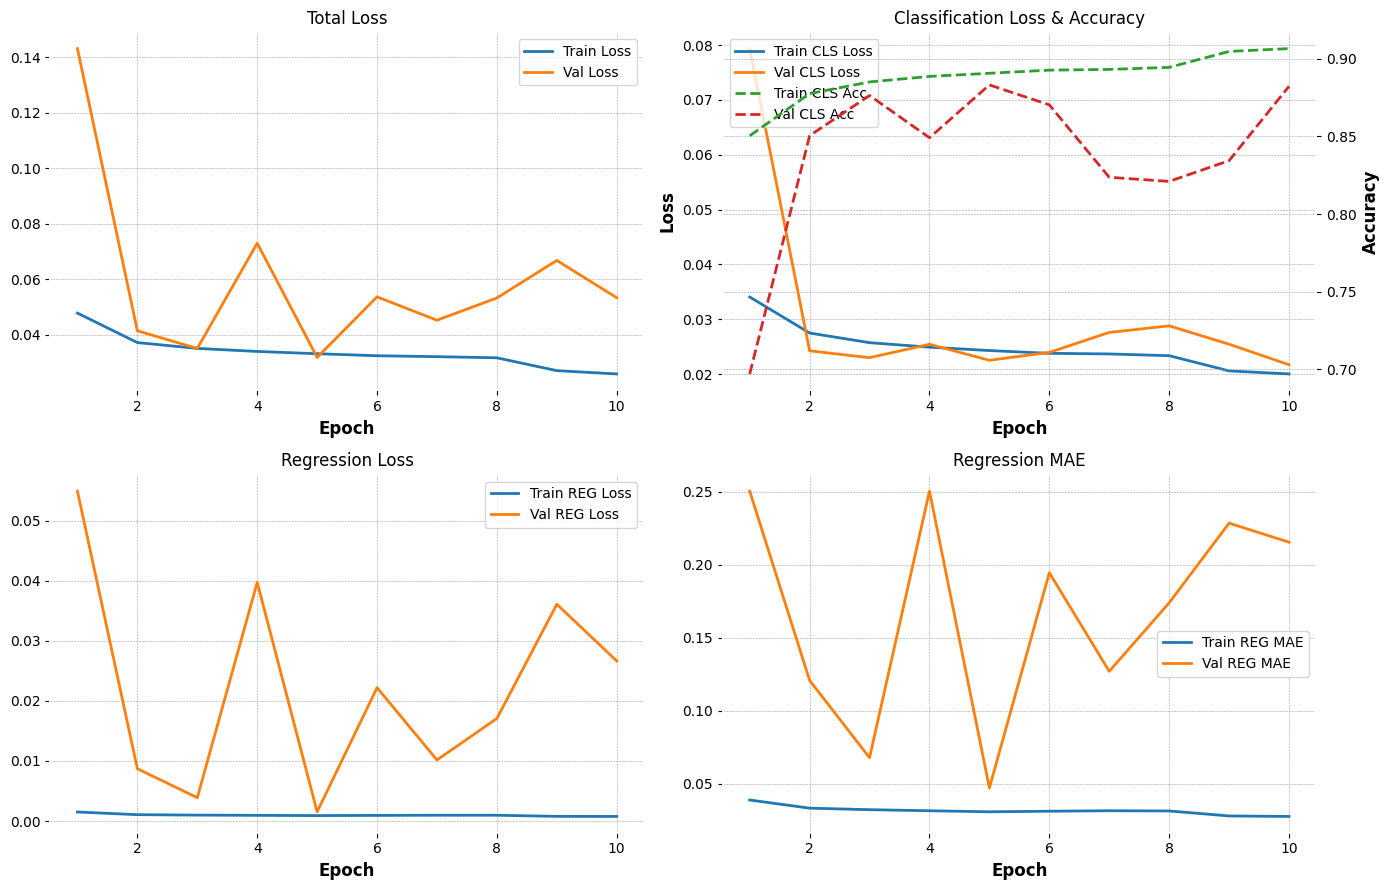

In [33]:
import matplotlib.pyplot as plt

def plot_history(history):
    h = history.history
    epochs = range(1, len(h['loss'])+1)

    plt.figure(figsize=(14, 9))

    # 1. Overall loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, h['loss'], label='Train Loss')
    if 'val_loss' in h:
        plt.plot(epochs, h['val_loss'], label='Val Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # 2. Classification loss & accuracy (two y-axes)
    ax1 = plt.subplot(2, 2, 2)
    ax1.plot(epochs, h.get('classification_loss', []), label='Train CLS Loss', color='tab:blue')
    if 'val_classification_loss' in h:
        ax1.plot(epochs, h['val_classification_loss'], label='Val CLS Loss', color='tab:orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2 = ax1.twinx()
    if 'classification_accuracy' in h:
        ax2.plot(epochs, h['classification_accuracy'], '--', label='Train CLS Acc', color='tab:green')
    if 'val_classification_accuracy' in h:
        ax2.plot(epochs, h['val_classification_accuracy'], '--', label='Val CLS Acc', color='tab:red')
    ax2.set_ylabel('Accuracy')

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax1.set_title('Classification Loss & Accuracy')

    # 3. Regression loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, h.get('regression_loss', []), label='Train REG Loss')
    if 'val_regression_loss' in h:
        plt.plot(epochs, h['val_regression_loss'], label='Val REG Loss')
    plt.title('Regression Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # 4. Regression MAE
    plt.subplot(2, 2, 4)
    plt.plot(epochs, h.get('regression_mae', []), label='Train REG MAE')
    if 'val_regression_mae' in h:
        plt.plot(epochs, h['val_regression_mae'], label='Val REG MAE')
    plt.title('Regression MAE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_history(history)
